In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import corner
from scipy import integrate
import pickle

In [2]:
import xoflares
from flarefinder import *

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(xoflares.__version__)

0.1.6
1.0.4
3.6
0.1.0


In [4]:
l = Lightcurve()
l.add_data('AU Mic')
#l.add_data(curve='https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018206045859-s0001-0000000441420236-0120-s_tp.fits')

code runs lc.flatten()


In [5]:
o = OddsRatioDetector(l)
lnO, ts = o.oddsratio()
flarelist, Nflares, maxlist = o.thresholder(lnO, thresh = 50, expand=0, returnmax=True)

In [6]:
print(flarelist)

[(998, 1000), (1806, 1826), (2159, 2318), (2420, 2422), (2813, 2892), (3357, 3373), (3824, 3826), (5804, 6065), (6123, 6144), (6801, 7049), (7197, 7242), (8052, 8200), (9194, 9240), (11956, 11968), (13244, 13410), (13860, 13875), (14049, 14155), (14729, 14745), (15348, 15349), (15378, 15415), (15709, 15720), (15774, 16005), (16037, 16065), (17507, 17508)]


In [7]:
l.time /=(24*3600)


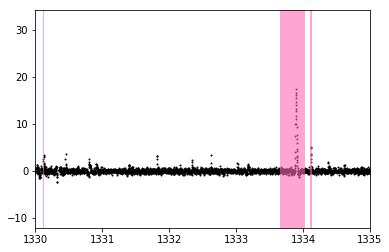

In [8]:
for i in flarelist:
    plt.axvspan(l.time[i[0]], l.time[i[1]], facecolor='hotpink', alpha = .6)

# plt.xlim(l.time.min,l.time.max)   
#plt.ylim(-.0001,.0001)
plt.xlim(1330,1335)   
plt.scatter(l.time, l.flux,s=1,c='k')

(1325.3014246025107, 1353.1675721011552)

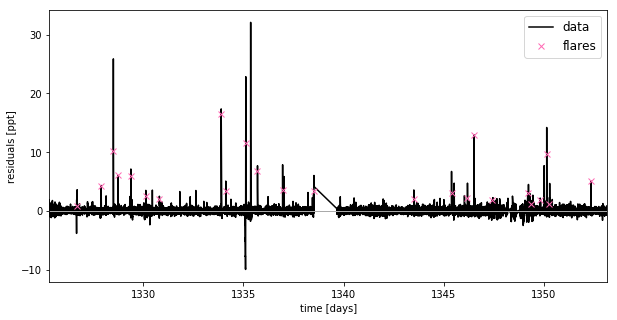

In [9]:
peaks = []

for i in range(len(maxlist)):
    peaks.append(maxlist[i][1])

# for i in range(len(maxlist)):
#     amp.append((maxlist[i][0]))
amp = l.flux[peaks]

plt.figure(figsize=(10, 5))
plt.plot(l.time, l.flux, "k", label="data")
plt.plot(l.time[peaks], l.flux[peaks], "x", color = "hotpink", label="flares")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=1)
#plt.xlim(1330,1335)
plt.xlim(l.time.min(), l.time.max())

In [10]:
#l.flux = (l.flux - 1.0)  * 1e3
# l.time = l.time/24*3600
### don't know what this is
# texp = lcf.hdu[1].header['FRAMETIM'] * lcf.hdu[1].header["NUM_FRM"]
# texp /= 60.0 * 60.0 * 24.0
texp = 0.001388888888888889
ref_time = 0.5 * (l.time.min() + l.time.max())
print(ref_time)

#lc.plot(normalize=False, ylabel='Relative flux [ppt]')

1339.2344983518328


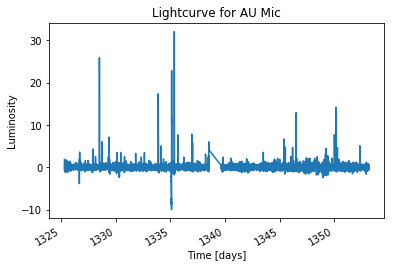

In [11]:
fig, ax = plt.subplots(1)
plt.title('Lightcurve for AU Mic')
ax.plot(l.time, l.flux)
fig.autofmt_xdate()
plt.xlabel('Time [days]')
plt.ylabel('Luminosity')
plt.show()

In [12]:
# find some flares
# mflare = l.flux < 3.5 * np.sqrt(np.mean(l.flux**2))
# print(mflare)


# HERE
cads = l.cadenceno - l.cadenceno[0]
x = l.time - ref_time
y = l.flux #  we're working with the data with a savgol subtracted


#number of points within each flare, get this from flarelist!
npts = []

for i in range(len(flarelist)):

    k = flarelist[i][1] - flarelist[i][0]
    npts.append(k)

        
tpeaks = x[peaks]
print(tpeaks)
ampls = amp
fwhms = np.asarray(npts) * (2/1440)
npeaks = Nflares


[-12.54279771 -11.33724525 -10.73030283 -10.49835921  -9.85530521
  -9.11225195  -8.43169897  -5.34283052  -5.11783314  -4.12062313
  -3.53174189  -2.27897994  -0.71649958   4.27227032   6.15832813
   6.95413797   7.28607243   8.19854446   9.96793245  10.11098332
  10.5845788   10.91095682  11.04845222  13.1178256 ]


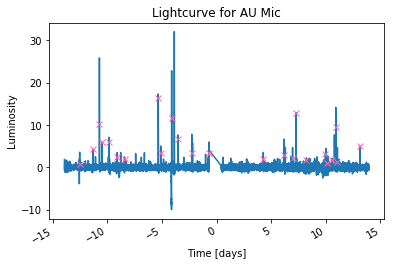

In [13]:
fig, ax = plt.subplots(1)
plt.title('Lightcurve for AU Mic')

plt.plot(x, l.flux)
plt.plot(tpeaks, ampls, "x", color = "hotpink", label="outliers")
fig.autofmt_xdate()
plt.xlabel('Time [days]')
plt.ylabel('Luminosity')
plt.show()

In [14]:
# fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
# axes = axes.flatten()
# for i in range(npeaks):
#     ax = axes[i]
#     ax.plot(x, y)
#     ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
#     ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
#     ax.set_ylim(np.min(y), np.max(ampls[i]+3))

Text(0, 0.5, 'power')

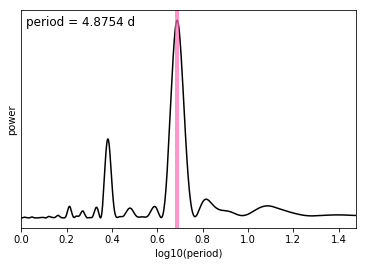

In [15]:
# determine the rotation period of the star
y = (l.raw_flux-1)*1e3
yerr = l.flux_error * 1e3

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="hotpink", lw=4, alpha=0.7)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power")

In [16]:
# GP model for smoothing using above period
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
        logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
        logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
        fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
        ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
        
        light_curve = xoflares.get_light_curve(x[mask], tpeak, fwhm, ampl, texp=texp, oversample=9)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curve

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, mean])
        map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
        map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak])
        map_soln = xo.optimize(start=map_soln, vars=[tpeak,fwhm, ampl])
    return model, map_soln

model0, map_soln0 = build_model()

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4311' (I am process '5103')
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -77673.22931260018 -> -26477.57517107385
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Optimization terminated successfully.
logp: -26477.57517107385 -> -16912.388816815386


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -16912.388816815386 -> -16340.732143634901
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -16340.732143634901 -> -16155.06886100414
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -16155.06886100414 -> -15852.269624744375


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -15852.269624744375 -> -15206.7759085472
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


message: Optimization terminated successfully.
logp: -15206.7759085472 -> -15139.992443695926
optimizing logp for variables: ['logs2', 'mean']
message: Optimization terminated successfully.
logp: -15139.992443695926 -> -15139.992443695926
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -15139.992443695926 -> -14765.759589838543
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14765.759589838543 -> -14587.534811371173
optimizing logp for variables: ['mean', 'logAmpl']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14587.534811371173 -> -14103.010620330322
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14103.010620330322 -> -14098.400441023117
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14098.400441023117 -> -14021.364667964568
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14021.364667964568 -> -14021.364667964568


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


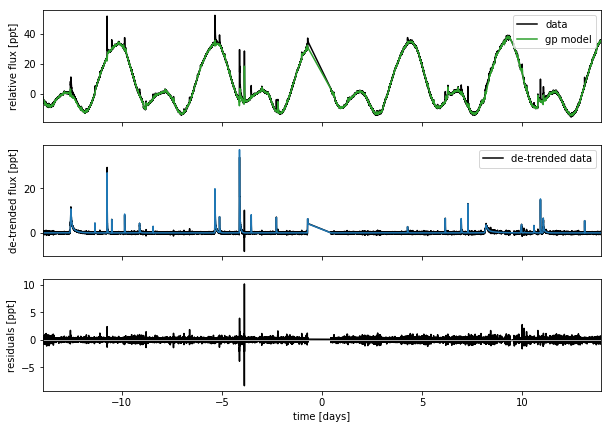

In [17]:
# plot the results of the model fitting + smoothing

def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curve = xo.utils.eval_in_model(model.light_curves, soln, model=model)

    mod = light_curve
    ax.plot(x[mask], mod,)
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + light_curve
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

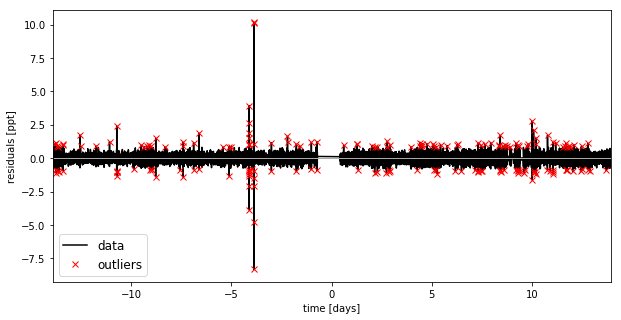

In [18]:
# subtract off the model to get residual (flatten light curve w/ spots/rotation removed)

mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14021.364667964568 -> -14011.699663555117
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -14011.699663555117 -> -13909.474687368715
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13909.474687368715 -> -13881.158222398757
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -13881.158222398757 -> -13879.261757984083
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13879.261757984083 -> -13879.143969620112
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13879.143969620112 -> -13863.302137070452
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13863.302137070452 -> -13836.331986679601
optimizing logp for variables: ['logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13836.331986679601 -> -13836.331986679601
optimizing logp for variables: ['logw', 'logS', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -13836.331986679601 -> -13825.816504256092
optimizing logp for variables: ['mean', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13825.816504256092 -> -13816.782324155061
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -13816.782324155061 -> -13815.402706344594
optimizing logp for variables: ['logAmpl', 'logFwhm']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13815.402706344594 -> -13815.286850896786
optimizing logp for variables: ['tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13815.286850896786 -> -13814.469853426657
optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13814.469853426657 -> -13812.614083508968


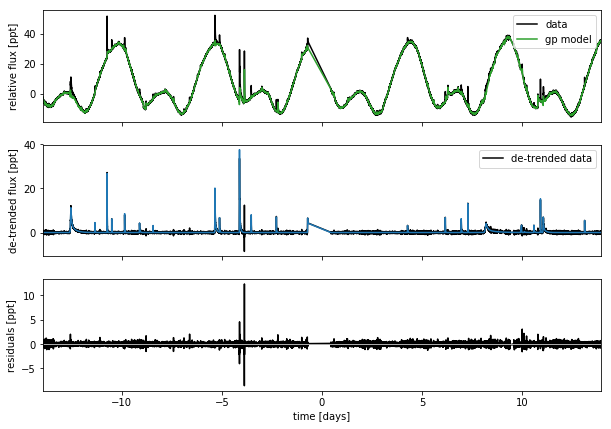

In [19]:

model, map_soln1 = build_model(mask=None, start=map_soln0)
fig = plot_light_curve(model, map_soln1, mask=None)

In [20]:
with model:
    map_soln2 = xo.optimize(start=map_soln1,)


optimizing logp for variables: ['logAmpl', 'logFwhm', 'tpeak', 'mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS', 'logs2', 'mean']


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

message: Desired error not necessarily achieved due to precision loss.
logp: -13812.614083508968 -> -13812.276897451438


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [21]:
with model:
    mean_field = pm.fit(method='advi', start=map_soln2,  n=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Average Loss = 14,090: 100%|██████████| 100000/100000 [3:31:57<00:00,  6.83it/s]   
Finished [100%]: Average Loss = 14,091


In [22]:
with model:
    trace = mean_field.sample(3000)

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Prot = 4.899113277508163 +0.05443579241423002 - 0.053043268826368006


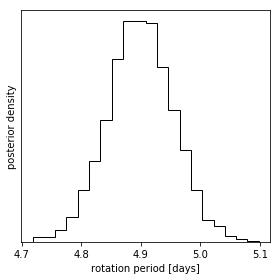

In [23]:
fig, axes = plt.subplots(1,1, figsize=[4, 4])
ax = axes
ax.hist( trace['period'], bins=20, histtype='step', color="k")
plt.yticks([])

ax.set_xlabel("rotation period [days]")
ax.set_ylabel("posterior density");

plt.tight_layout()
fig.savefig('aumic-rotation.png', dpi=200)
q = np.percentile(trace['period'], [16,50,84])
print('Prot = {} +{} - {}'.format(q[1], q[2] - q[1], q[1]-q[0]))


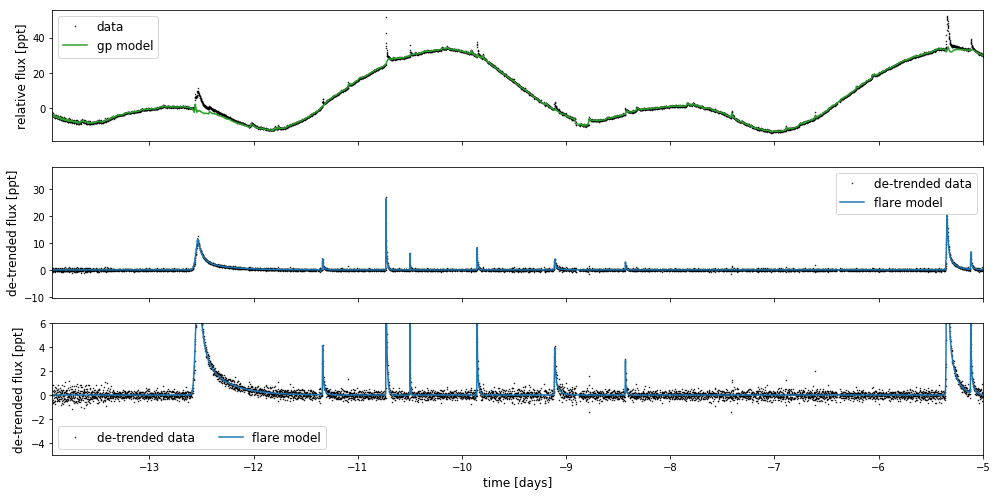

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

ax = axes[0]
ax.plot(x, y, ".k", label="data", ms=1)
gp_mod = np.median(trace['pred'], axis=0)
gp_mod += np.median(trace["mean"])
ax.plot(x, gp_mod, color="C2", label="gp model")
ax.legend(fontsize=12)
ax.set_ylabel("relative flux [ppt]", fontsize=12)

ax = axes[1]
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
light_curve = np.median(trace['light_curve'], axis=0)

mod = light_curve
ax.plot(x, mod, label='flare model')
ax.legend(fontsize=12)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)

ax = axes[2]
# mod = gp_mod + light_curve
# ax.plot(x, y - mod, "k")
# ax.axhline(0, color="#aaaaaa", lw=1)
# ax.set_ylabel("residuals [ppt]", fontsize=12)
ax.plot(x, y - gp_mod, ".k", label="de-trended data", ms=1)
ax.plot(x, mod, label='flare model')

ax.legend(fontsize=12, loc=3, ncol=2)
ax.set_ylabel("de-trended flux [ppt]", fontsize=12)
ax.set_ylim(-5,6)

ax.set_xlim(x.min(), -5)
#ax.set_xlim(0,10)
ax.set_xlabel("time [days]", fontsize=12)

plt.tight_layout()

In [25]:
print(x)

[-13.93307375 -13.93168486 -13.93029597 ...  13.93029608  13.93168491
  13.93307375]


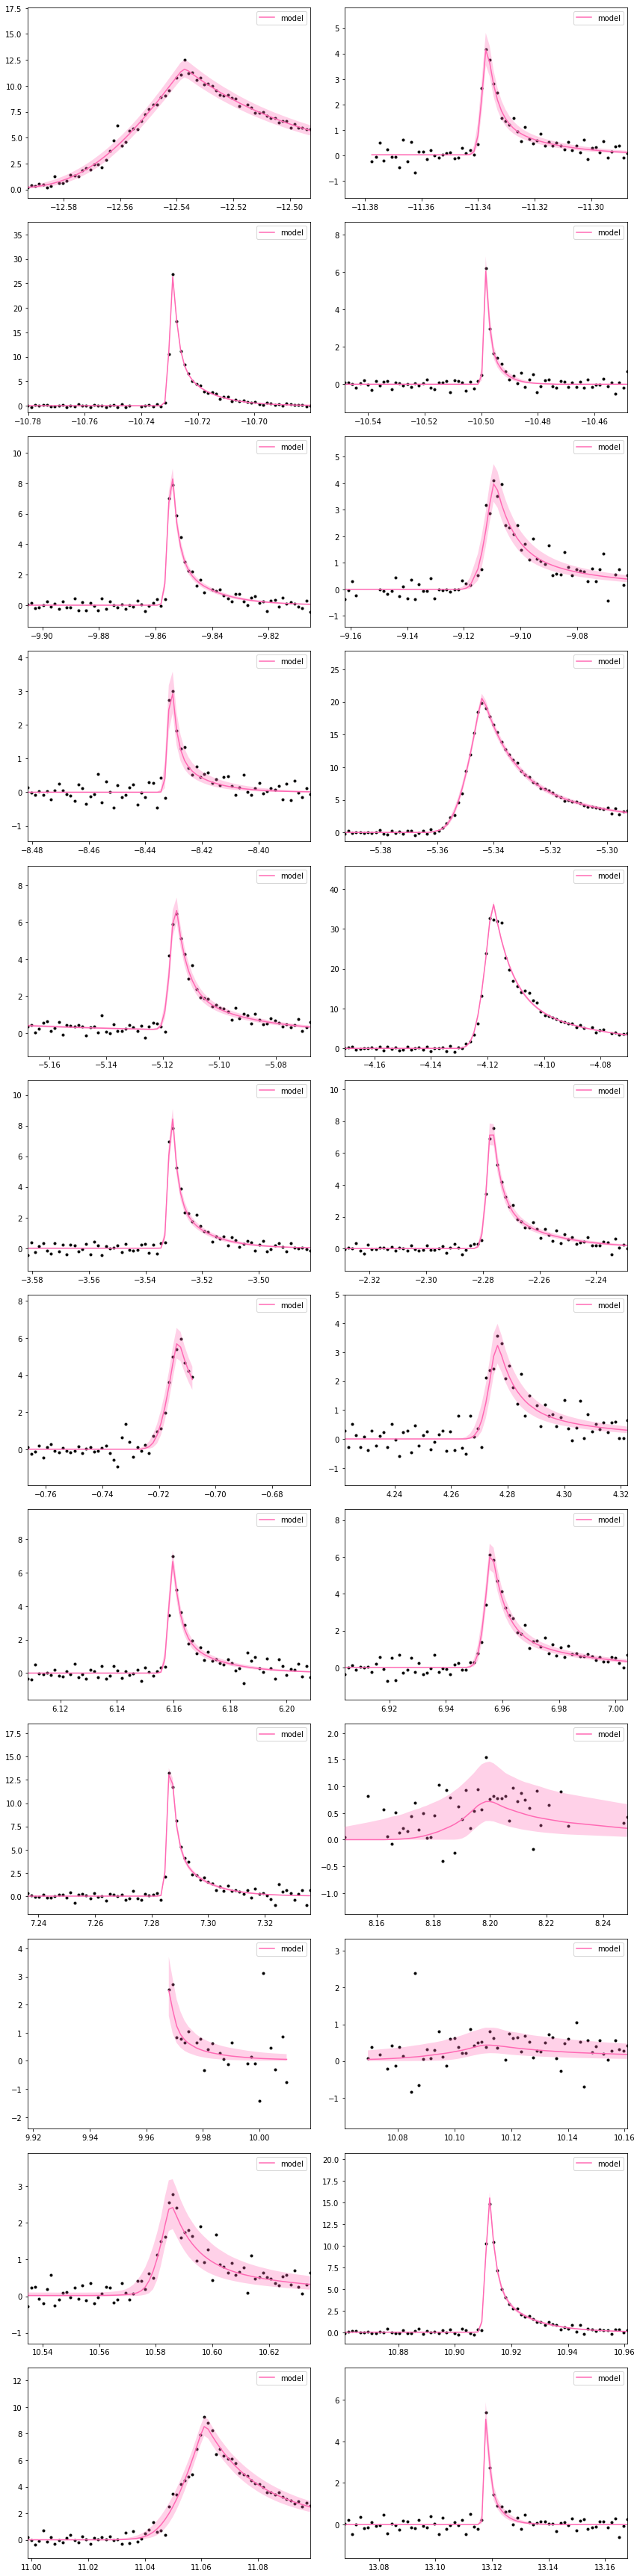

In [140]:
flc =  np.percentile(trace['light_curve'], [16, 50, 84], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.05) * (x < tpeaks[i]+0.05)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask]-gp_mod[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="hotpink", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="hotpink", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.05)
    ax.set_ylim(np.min(y[timemask]-gp_mod[timemask]) - 1, .4*np.max(y[timemask]-gp_mod[timemask]) + np.max(y[timemask]-gp_mod[timemask]))
    ax.legend()
    

    fig.tight_layout()

In [181]:
def multiflaremodelnp(time, tpeaks, fwhms, ampls):
    time = np.asarray(time, dtype=float)
    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)
    multiflare_lc = np.zeros_like(time)
    npeaks = tpeaks.shape[0]
    for i in range(npeaks):
        flare_lc = _flaremodelnp(time, tpeaks[i], fwhms[i], ampls[i])
        multiflare_lc = multiflare_lc + flare_lc
    return multiflare_lc


def get_light_curvenp(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = np.asarray(time, dtype=float)

    tpeaks = np.atleast_1d(tpeaks)
    fwhms = np.atleast_1d(fwhms)
    ampls = np.atleast_1d(ampls)
    print(tpeaks, 'tpeaks')
    print(fwhms,'fwhms')
    print(ampls, 'ampls')

    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        texp = float(texp)
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = (dt + time.reshape(time.size, 1)).flatten()

    multiflare_lc = multiflaremodelnp(tgrid, tpeaks, fwhms, ampls)

    if texp is not None:
        multiflare_lc = np.mean(
            multiflare_lc.reshape(-1, oversample),
            axis=1)

    return multiflare_lc

def _flaremodelnp(time, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    flare_lc = np.zeros_like(time)
    flare_lc = np.where((time <= tpeak) * ((time - tpeak) / fwhm > -1.),
                        (_fr[0] +
                         _fr[1] * ((time - tpeak) / fwhm) +
                         _fr[2] * ((time - tpeak) / fwhm)**2. +
                         _fr[3] * ((time - tpeak) / fwhm)**3. +
                         _fr[4] * ((time - tpeak) / fwhm)**4.) *
                        ampl,
                        flare_lc
                        )
    flare_lc = np.where((time > tpeak) * ((time - tpeak) / fwhm < 20.),
                        (_fd[0] * np.exp(((time - tpeak) / fwhm) * _fd[1]) +
                         _fd[2] * np.exp(((time - tpeak) / fwhm) * _fd[3])) *
                        ampl,
                        flare_lc
                        )
    return flare_lc

In [191]:
def get_flare_integral(time, tpeak, fwhm, ampl, texp=None, oversample=7):
    """
    calculates the integral of flares. Useful for calculating
    equivalent width and energy
    this is designed to be a post processing step, not run within the
    HMC model. This is mostly because it is slightly awkward to implement
    and integral in theano
    """
    feval = get_light_curvenp(time,
                              tpeak,
                              fwhm,
                              ampl,
                              texp,
                              oversample)
    #check this line vvv will that help with negative energy values?
#     print(feval, 'feval')
#     print(len(time[feval > 0]), 'greater than 0 pts')
#     print(time[feval > 0])
    

#     tstart, tend = time[feval > 0][0], time[feval > 0][-1]
#     print(tstart, 'tstart',tend, 'tend')
#     integral = integrate.quad(xoflares.get_light_curvenp, tstart, tend,
#                               points=tpeak,
#                               args=(tpeak, fwhm, ampl, texp, oversample))
    feval_un_tom = feval/1000. + 1.
    plt.scatter(time,feval_un_tom)
    plt.show()
    integral = np.trapz(feval_un_tom, time)

    return integral

In [29]:
# filename = 'flare_results'
# outfile = open(filename,'wb')
# pickle.dump([x, y, peaks], outfile)
# outfile.close()

In [30]:
# filename = 'flare_results_trace'
# outfile = open(filename,'wb')
# pickle.dump(trace, outfile)
# outfile.close()

In [192]:
trace = pickle.load(open('flare_results_trace', 'rb'))
x, y, peaks = pickle.load(open('flare_results', 'rb'))

In [145]:
print(len(trace['ampl'][:,0]))
#print(np.median(trace['ampl'][:,1]))

3000


In [146]:
len(trace[0])
for i in range(len(trace[0])):
#     print(np.median(trace['tpeak'][:,i]))
#     print(np.median(trace['fwhm'][:,i]))
    amp_0 = np.median(trace['ampl'][:,i])
    print((amp_0+1)/1000)

0.012833406622030847
0.005819358163844088
0.03346533215764379
0.01087095605387891
0.011545373631032842
0.005366875552025706
0.004970826609425782
0.022445753314492046
0.008460030510887067
0.039483884480176513
0.011817774177277062
0.00985684936417288
0.007205863933513113
0.00460698569639522
0.008815157074804169
0.007852439198938712
0.019225295051970005
0.0018437039103853278


In [147]:
trace['tpeak'][2000]

array([-12.53797166, -11.33682617, -10.72916755, -10.4987776 ,
        -9.85468377,  -9.10907241,  -8.43096934,  -5.34451419,
        -5.11583652,  -4.11820039,  -3.53093591,  -2.27723737,
        -0.71457215,   4.2764108 ,   6.15962414,   6.95580394,
         7.2863536 ,   8.20044275,   9.967326  ,  10.11063209,
        10.58516002,  10.91190984,  11.06072391,  13.11757037])

In [148]:
print(len(trace['fwhm'][:,2]))
print(len(trace['fwhm'][2]))

3000
24


In [149]:
# e, e_err = get_flare_integral(x, (trace['tpeak']),(trace['fwhm']),(trace['ampl'] + 1)/1000)
# print(e)
# print(e_err)

[-12.53727389] tpeaks
[0.06491155] fwhms
[11.83340662] ampls
-12.601130920700825 tstart -11.24002333494991 tend


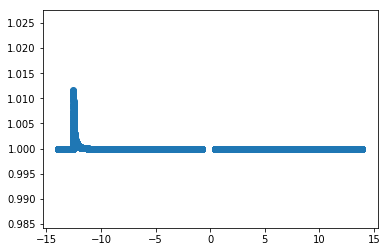

[-11.33710769] tpeaks
[0.00525511] fwhms
[4.81935816] ampls
-11.341411908616465 tstart -11.233078912114934 tend


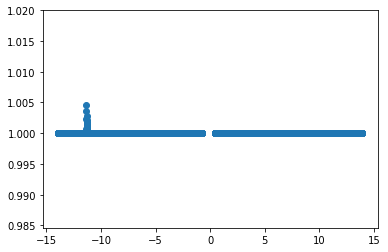

[-10.72916403] tpeaks
[0.00280651] fwhms
[32.46533216] ampls
-10.731691716062642 tstart -10.673358593866624 tend


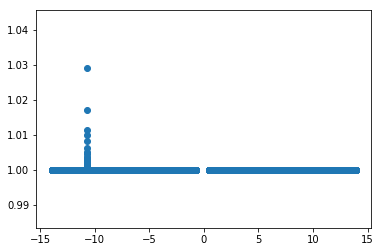

[-10.49852732] tpeaks
[0.00120999] fwhms
[9.87095605] ampls
-10.498359213397634 tstart -10.4747481527329 tend


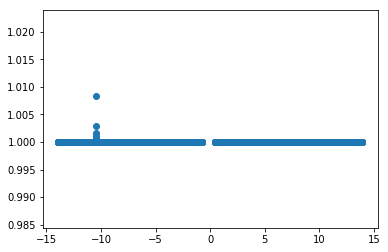

[-9.85463792] tpeaks
[0.00340704] fwhms
[10.54537363] ampls
-9.856694095505645 tstart -9.787249842434221 tend


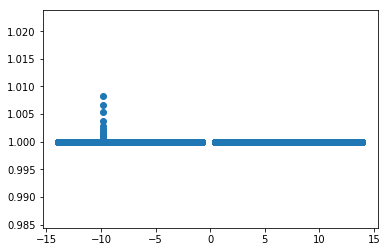

[-9.10941079] tpeaks
[0.01076345] fwhms
[4.36687555] ampls
-9.119196366210872 tstart -8.905308236810924 tend


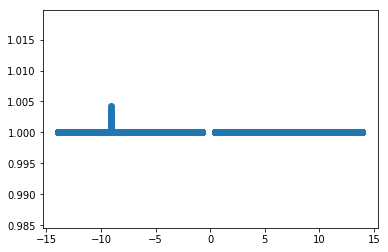

[-8.43111268] tpeaks
[0.00295095] fwhms
[3.97082661] ampls
-8.433087854227779 tstart -8.373365881057225 tend


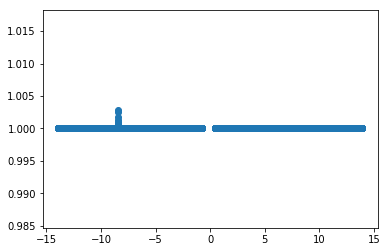

[-5.34413369] tpeaks
[0.01767323] fwhms
[21.44575331] ampls
-5.360885867729394 tstart -4.991445750053799 tend


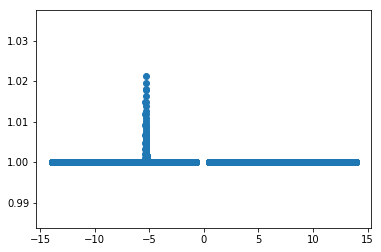

[-5.11573894] tpeaks
[0.00597822] fwhms
[7.46003051] ampls
-5.120610888578085 tstart -4.997001239547899 tend


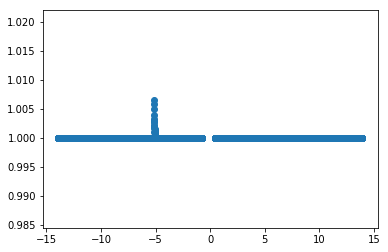

[-4.11826747] tpeaks
[0.01058972] fwhms
[38.48388448] ampls
-4.127567490276306 tstart -3.9067369858207712 tend


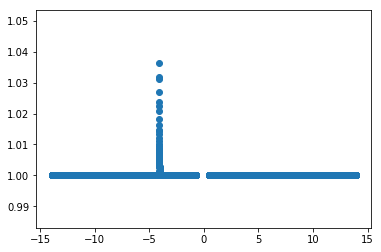

[-3.53100195] tpeaks
[0.00297751] fwhms
[10.81777418] ampls
-3.533130759876258 tstart -3.4720204597306292 tend


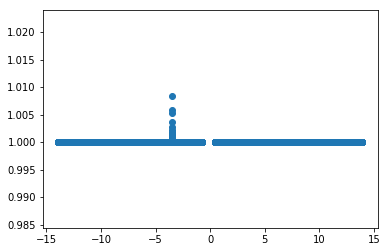

[-2.27714957] tpeaks
[0.00508343] fwhms
[8.85684936] ampls
-2.2817576868621927 tstart -2.1762033687405165 tend


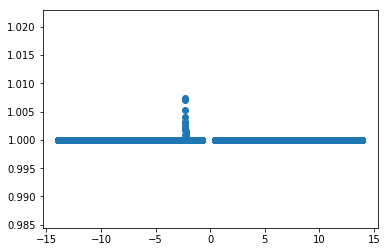

[-0.7134805] tpeaks
[0.01215731] fwhms
[6.20586393] ampls
-0.7248327902730125 tstart -0.7081663593564826 tend


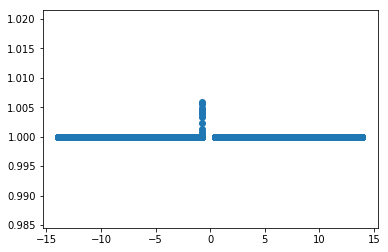

[4.27603952] tpeaks
[0.01006055] fwhms
[3.6069857] ampls
4.266714915731427 tstart 4.476431375459924 tend


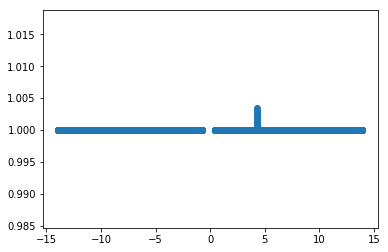

[6.15942721] tpeaks
[0.00395138] fwhms
[7.81515707] ampls
6.155550432659538 tstart 6.237492486035308 tend


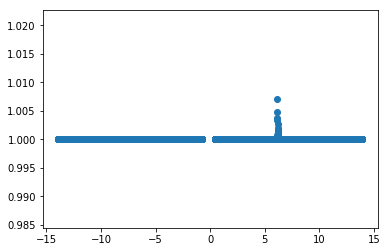

[6.95588104] tpeaks
[0.00735092] fwhms
[6.8524392] ampls
6.948582578978858 tstart 7.102744624946354 tend


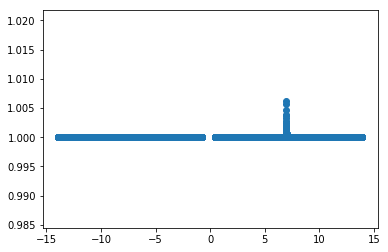

[7.28639681] tpeaks
[0.00280898] fwhms
[18.22529505] ampls
7.284683587236714 tstart 7.341626309191952 tend


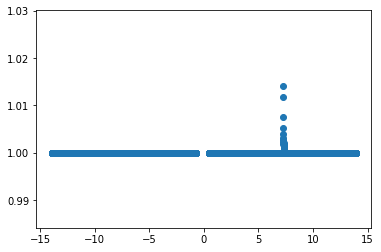

[8.19829626] tpeaks
[0.03396973] fwhms
[0.84370391] ampls
8.165212164501327 tstart 8.861023650135394 tend


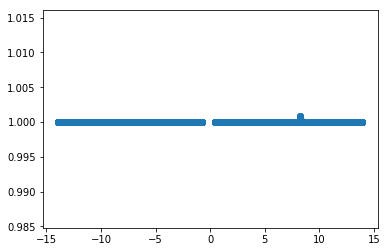

[9.96721365] tpeaks
[0.00302326] fwhms
[3.66787623] ampls
9.96793244554351 tstart 10.009597749599152 tend


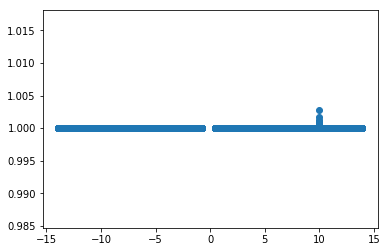

[10.11093069] tpeaks
[0.05400101] fwhms
[0.48273052] ampls
10.06931801630958 tstart 11.190114125995933 tend


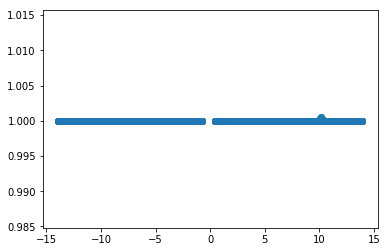

[10.58507533] tpeaks
[0.01321576] fwhms
[2.63777817] ampls
10.572079218151885 tstart 10.848458910051477 tend


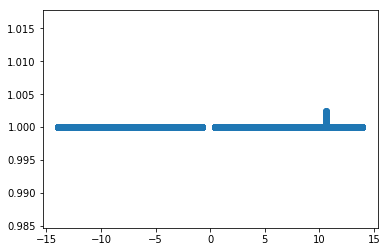

[10.91192794] tpeaks
[0.00320412] fwhms
[18.73784899] ampls
10.909567979888152 tstart 10.974843574124861 tend


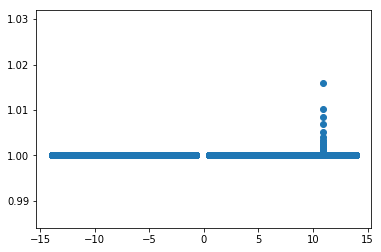

[11.06117319] tpeaks
[0.02671006] fwhms
[8.83406422] ampls
11.034563795665008 tstart 11.594267115362072 tend


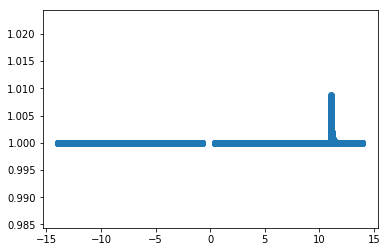

[13.11779335] tpeaks
[0.00109773] fwhms
[9.01434555] ampls
13.117825603138272 tstart 13.13865820144747 tend


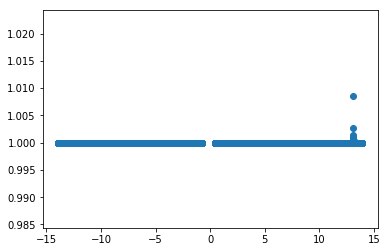

In [193]:
energy = []
energy_err = []
# print(x)
for i in range(len(peaks)):

# i = 2
#     print(i)
#     amp_0 = (trace['ampl'][:,i])
#     q = ((amp_0+1)/1000)
    e = get_flare_integral(x, np.median(trace['tpeak'][:,i]),np.median(trace['fwhm'][:,i]),np.median((trace['ampl'][:,i])))# + 1)/1000)
    energy.append(e)

In [153]:
# amp_0 = np.median(trace['ampl'][:,39])
# q = ((amp_0+1)/1000)
# print(x, np.median(trace['tpeak'][:,39]), np.median(trace['fwhm'][:,39]),q )
# test_e, test_e_err = get_flare_integral(x, np.median(trace['tpeak'][:,39]), 
#                                         np.median(trace['fwhm'][:,39]),q )
#                                     #, texp=0.001388888888888889, oversample=7)
# print(test_e)

In [194]:
int_energy = np.sort(np.asarray(energy))
print(energy)
d = 3.0008e19 #5.84e10 #distance in cm
ref_energy = 1.0577483864655743e-08
abs_energy = []
for i in range(len(energy)):
    abs = energy[i] * ref_energy * 4 * np.pi * (d)**2 
    abs_energy.append(abs)
#abs_energy = energy * 1.0545626596025542e-09 * 4 * np.pi * (3.0008*10**19)**2 
#distance to star, 9.7248 ±0.004 pc, include errors eventually

#print(abs_energy)

[27.867547573016946, 27.866193896077213, 27.866314104694528, 27.866171060008167, 27.866212177088727, 27.86623350377363, 27.866168536473346, 27.866838820657172, 27.866228453085363, 27.86688962363526, 27.866205258188426, 27.866229343228888, 27.868356667379093, 27.866213604521167, 27.866203770008607, 27.86623929370016, 27.866240677102184, 27.866199889776663, 27.866237623932335, 27.86619538785719, 27.866211011557066, 27.86625600594315, 27.86657767434689, 27.86616960959838]


In [186]:
# test = [8.73801837e+28, 7.82553746e+28, 9.41446321e+28, 8.14190824e+28,
#  8.75899300e+28, 1.28882346e+29, 1.11288733e+29, 8.62745477e+28,
#  7.64379674e+28, 9.94271496e+28, 9.39896789e+28, 7.88441445e+28,
#  1.34538984e+29, 8.47620326e+28, 1.75032907e+29, 1.02497855e+29,
#  9.64796083e+28, 1.10694969e+29, 7.67359195e+28, 1.78083418e+29,
#  1.85005326e+29, 1.73665574e+29, 9.11936008e+28, 1.02400155e+29,
#  1.09631191e+29, 1.08419602e+29, 7.52530910e+28, 8.25961754e+28,
#  7.81249901e+28, 8.37943178e+28, 9.86278999e+28, 1.15182293e+29,
#  1.03885841e+29, 1.17206960e+29, 1.08379824e+29, 1.07945727e+29,
#  7.65964640e+28, 1.09242340e+29, 9.08392594e+28, 1.03042328e+29,
#  7.23766425e+28]

In [187]:
# abs_energy = (np.array(test) / (3.0008e19)**2 ) * (5.84e10)**2 

In [188]:
sort = np.sort(abs_energy)
print(sort)

[3.33536677e+33 3.33536690e+33 3.33536707e+33 3.33536980e+33
 3.33536998e+33 3.33537052e+33 3.33537098e+33 3.33537116e+33
 3.33537185e+33 3.33537199e+33 3.33537216e+33 3.33537394e+33
 3.33537405e+33 3.33537454e+33 3.33537504e+33 3.33537524e+33
 3.33537540e+33 3.33537724e+33 3.33538419e+33 3.33541574e+33
 3.33544700e+33 3.33545308e+33 3.33553183e+33 3.33562867e+33]


In [189]:
# hist, bins = np.histogram(sort)
# freq = hist/t_obs
# plt.scatter(bins[:-1], freq)
# plt.ylabel('Cumulative # of Flares per Day')
# plt.yscale('log')

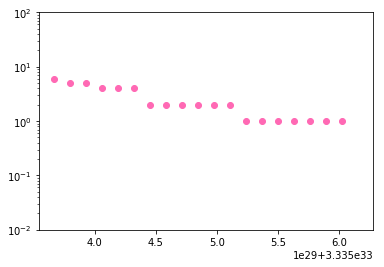

In [190]:
values, base = np.histogram(sort, bins=20)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
# plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
plt.scatter(base[:-1], len(sort)-cumulative, c='hotpink')
plt.yscale('log')
plt.ylim(.01, 100)
plt.show()

In [176]:
# need this in per day?
print(l.time)

[1.14506043e+08 1.14506163e+08 1.14506283e+08 ... 1.16913438e+08
 1.16913558e+08 1.16913678e+08]


25.130555555555556


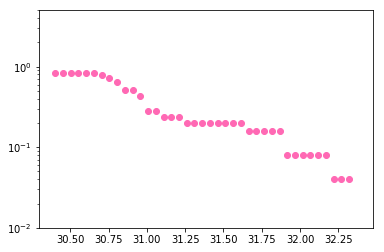

In [177]:
log_sort = np.log10(sort)
values, base = np.histogram(log_sort, bins=40)


#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
# plt.plot(base[:-1], cumulative, c='blue')
#plot the survival function
time_duration = (len(l.time)*2 / 60 / 24)
print(time_duration)
plt.scatter(base[:-1], (len(sort)-cumulative)/time_duration, c='hotpink')
plt.yscale('log')
# plt.xscale('log')
#plt.xlim(28.6,29.5)
plt.ylim(.01, 5)
plt.show()

In [164]:
# import seaborn as sns
# import matplotlib as mpl 

# mpl.rcParams['font.family'] = 'sansserif'
# sns.set(font='sansserif',font_scale=1)
# import itertools
# import matplotlib as mpl
# color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
#                               'darkorange'])
# fontsize=30
# sns.set(context="paper",font_scale=2., font='serif',style='ticks')

In [165]:
# yticks = [0.01,0.1,1,10]
# plt.gca().set_yticks(yticks)
# plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


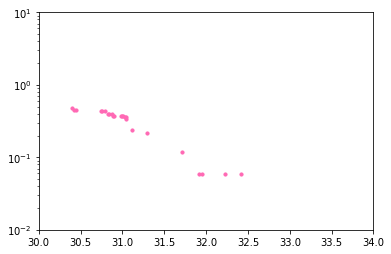

In [179]:
n_bins = len(log_sort)
counts, bin_edges = np.histogram(log_sort, bins=n_bins, normed=True)
cdf = np.cumsum(counts)

# sns.set_style("white")
# plt.figure(figsize=(18,13))
# plt.scatter(bin_edges[:-1], (len(log_sort)- cdf)/time_duration)

x = []
y= []
for i in range(len(log_sort)):
    x.append(log_sort[i])
    y.append(cdf[i]/time_duration)

x = x[::-1]
plt.yscale('log')
plt.ylim(0.01,10)
plt.xlim(30,34)
plt.scatter(x,y, c='hotpink',s=10)

In [131]:
l = Lightcurve()
l.add_data('AU Mic')

o = OddsRatioDetector(l)
lnO, ts = o.oddsratio()
flarelist, Nflares, maxlist = o.thresholder(lnO, thresh = 10, expand=0, returnmax=True)



code runs lc.flatten()


In [132]:
# print(flarelist)
print(len(maxlist))

a = []
for i in range(len(flarelist)):
    x1 = (flarelist[i][1]) - (flarelist[i][0])
    y1 = maxlist[i][0]
    a.append(.5*x1 * y1)

print(len(a))
print(np.sort(a))


51
51
[5.02777606e+00 5.28614814e+00 5.48152366e+00 1.03076740e+01
 1.07402775e+01 1.12616941e+01 1.15337851e+01 1.62957857e+01
 1.69675195e+01 2.18620071e+01 2.21541975e+01 3.15546622e+01
 3.89436859e+01 4.12430275e+01 7.18612944e+01 7.42667293e+01
 8.89068183e+01 1.16470993e+02 1.32577984e+02 1.37835237e+02
 2.17480312e+02 2.45371359e+02 2.56458439e+02 3.66481071e+02
 5.23868020e+02 5.48430639e+02 5.64406666e+02 6.13803439e+02
 6.17424098e+02 6.19752758e+02 6.43894350e+02 7.44224299e+02
 9.40307297e+02 1.04817349e+03 1.65509296e+03 2.05812525e+03
 2.82954026e+03 3.08418212e+03 3.09194609e+03 4.49404099e+03
 6.14080234e+03 2.13188334e+04 2.20051830e+04 2.76261702e+04
 2.95399261e+04 6.47640097e+04 7.54451509e+04 2.18187383e+05
 2.62210094e+05 1.12595064e+06 1.16041870e+06]


/Users/emilygilbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


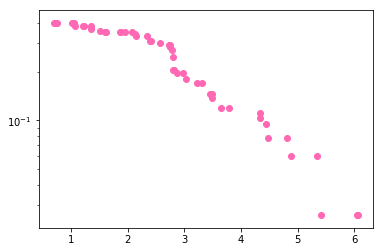

In [133]:
sort = np.sort(a)
log_sort = np.log10(sort)

time_duration = 25.130555555555556
counts, bin_edges = np.histogram(log_sort, bins=59, normed=True)
cdf = np.cumsum(counts)

# sns.set_style("white")
# plt.figure(figsize=(18,13))
# plt.scatter(bin_edges[:-1], (len(log_sort)- cdf)/time_duration)

x = []
y= []
for i in range(len(log_sort)):
    x.append(log_sort[i])
    y.append(cdf[i]/time_duration)

x = x[::-1]
plt.yscale('log')
plt.scatter(x,y, c='hotpink')